<a href="https://colab.research.google.com/github/AuguB/pcntoolkit_doc_notebooks/blob/main/scripts/other_predictive_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo.git

Cloning into 'PCNtoolkit-demo'...
remote: Enumerating objects: 1237, done.
remote: Counting objects: 100% (360/360), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 1237 (delta 200), reused 306 (delta 172), pack-reused 877 (from 1)
Receiving objects: 100% (1237/1237), 141.45 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (562/562), done.
Updating files: 100% (70/70), done.


In [2]:

import os

In [3]:
os.chdir('/content/PCNtoolkit-demo/')

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, linalg
from sklearn import preprocessing, decomposition, linear_model, metrics
import warnings

In [6]:
# set fontsizes for matplotlib plots
baseline_fontsize = 12
SMALL_SIZE = 8 + baseline_fontsize
MEDIUM_SIZE = 10 + baseline_fontsize
BIGGER_SIZE = 12 + baseline_fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Load Data

In [7]:
hcp_z = np.load('data/hcpya_z.npy')
hcp_ct = np.load('data/hcpya_ct.npy')
gscores = np.load('data/hcpya_g.npy')

In [8]:
print(hcp_z.shape)
print(hcp_ct.shape)
print(gscores.shape)

(946, 187)
(946, 151)
(946,)


# Create Train/Test Splits

In [9]:
# generate train/test splits
np.random.seed(42)
n_train = int(0.8 * hcp_z.shape[0])

train_idxs = np.random.choice(range(hcp_z.shape[0]), size=n_train, replace=False)
test_idxs = np.array([x for x in range(hcp_z.shape[0]) if x not in train_idxs])

In [10]:
train_data_z = hcp_z[train_idxs, :]
test_data_z = hcp_z[test_idxs, :]

train_data_ct = hcp_ct[train_idxs, :]
test_data_ct = hcp_ct[test_idxs, :]

train_phen = gscores[train_idxs]
test_phen = gscores[test_idxs]

In [11]:
# mean center train/test data (using train means)
train_mu_centered_z = (train_data_z - train_data_z.mean(axis=0))
test_mu_centered_z = (test_data_z - train_data_z.mean(axis=0))

train_mu_centered_ct = (train_data_ct - train_data_ct.mean(axis=0))
test_mu_centered_ct = (test_data_ct - train_data_ct.mean(axis=0))

# Principal Component Regression (BBS)

In [12]:
pca_model_z = decomposition.PCA(n_components=75).fit(train_data_z)
# from pca documentation, "the input data is centered but not scaled for each feature before applying the SVD"

In [13]:
pca_model_ct = decomposition.PCA(n_components=75).fit(train_data_ct)
# from pca documentation, "the input data is centered but not scaled for each feature before applying the SVD"

First PC explains 23.41% of the total variance.
This is an artifact of zero inflated data


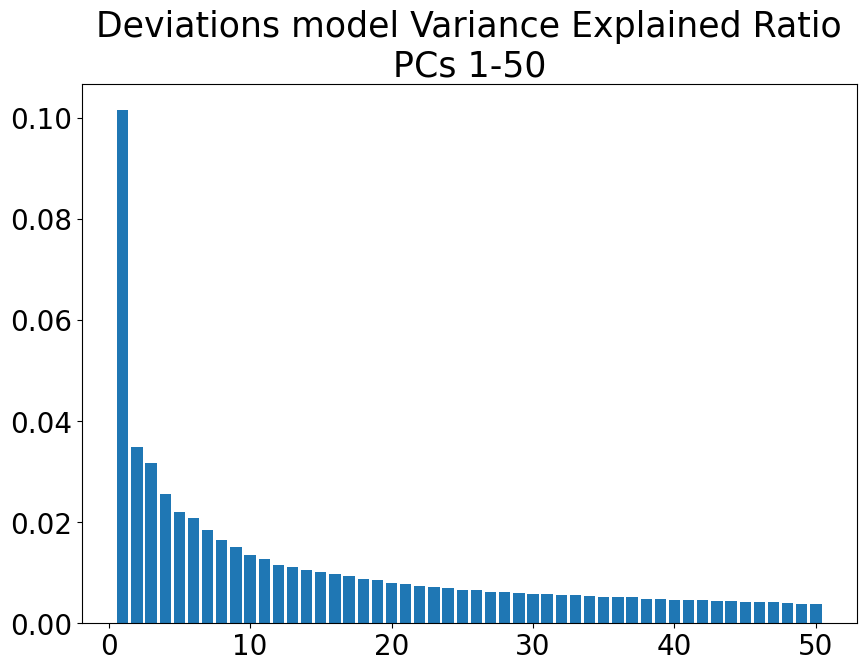

In [14]:
print(f'First PC explains {pca_model_z.explained_variance_ratio_[0]*100:.2f}% of the total variance.\nThis is an artifact of zero inflated data')
plt.figure(figsize=(10, 7))
plt.bar(range(1, 51), pca_model_z.explained_variance_ratio_[1:51])
plt.title('Deviations model Variance Explained Ratio\nPCs 1-50', fontsize=25)
plt.show()

First PC explains 24.28% of the total variance.
This is an artifact of zero inflated data


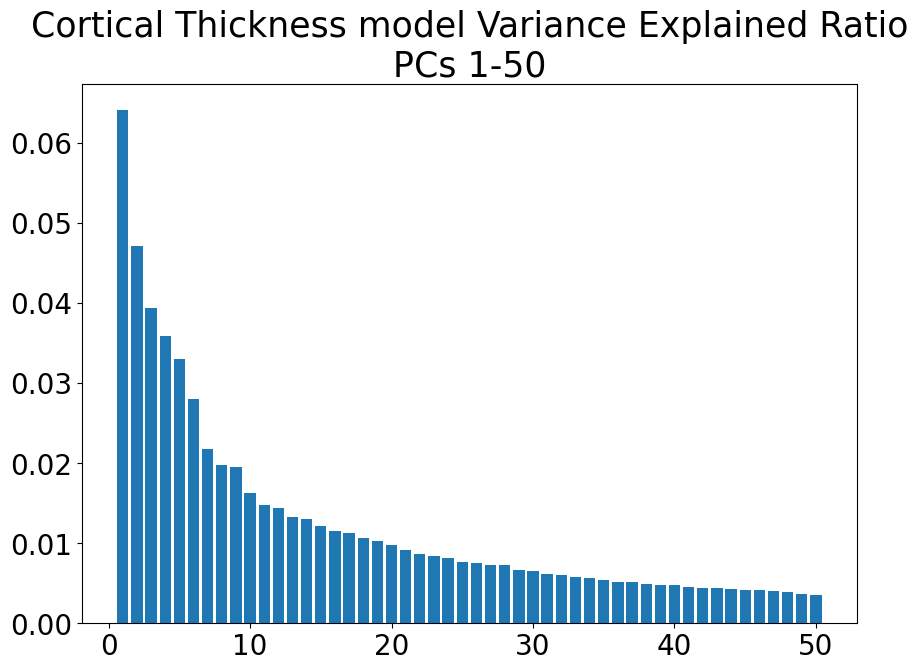

In [15]:
print(f'First PC explains {pca_model_ct.explained_variance_ratio_[0]*100:.2f}% of the total variance.\nThis is an artifact of zero inflated data')
plt.figure(figsize=(10, 7))
plt.bar(range(1, 51), pca_model_ct.explained_variance_ratio_[1:51])
plt.title('Cortical Thickness model Variance Explained Ratio\nPCs 1-50', fontsize=25)
plt.show()

In [16]:
train_transformed_z = pca_model_z.transform(train_data_z)
test_transformed_z = pca_model_z.transform(test_data_z)

In [17]:
train_transformed_ct = pca_model_ct.transform(train_data_ct)
test_transformed_ct = pca_model_ct.transform(test_data_ct)

## Fit Linear Regression Model

In [18]:
# fast OLS using matrix math
# we will check that this matches sklearn results later

# fit ols model on dimension reduced train data
train_features_z = np.hstack([np.ones((train_transformed_z.shape[0], 1)),
                            train_transformed_z])
train_features_inv_z = linalg.pinv(train_features_z)
train_betas_z = np.dot(train_features_inv_z, train_phen)
train_pred_phen_z = np.dot(train_features_z, train_betas_z)

# fit ols model on dimension reduced test data
test_features_z = np.hstack([np.ones((test_transformed_z.shape[0], 1)),
                           test_transformed_z])
test_pred_phen_z = np.dot(test_features_z, train_betas_z)

In [19]:
# fast OLS using matrix math
# we will check that this matches sklearn results later

# fit ols model on dimension reduced train data
train_features_ct = np.hstack([np.ones((train_transformed_ct.shape[0], 1)),
                            train_transformed_ct])
train_features_inv_ct = linalg.pinv(train_features_ct)
train_betas_ct = np.dot(train_features_inv_ct, train_phen)
train_pred_phen_ct = np.dot(train_features_ct, train_betas_ct)

# fit ols model on dimension reduced test data
test_features_ct = np.hstack([np.ones((test_transformed_ct.shape[0], 1)),
                           test_transformed_ct])
test_pred_phen_ct = np.dot(test_features_ct, train_betas_ct)

In [20]:
# OLS using sklearn

lr_model_z = linear_model.LinearRegression(fit_intercept=True)
lr_model_z.fit(train_transformed_z, train_phen)
train_pred_phen_lr_model_z = lr_model_z.predict(train_transformed_z)
test_pred_phen_lr_model_z = lr_model_z.predict(test_transformed_z)

In [21]:
# OLS using sklearn

lr_model_ct = linear_model.LinearRegression(fit_intercept=True)
lr_model_ct.fit(train_transformed_ct, train_phen)
train_pred_phen_lr_model_ct = lr_model_ct.predict(train_transformed_ct)
test_pred_phen_lr_model_ct = lr_model_ct.predict(test_transformed_ct)

In [22]:
# ensure matrix math predictions and sklearn predictions are accurate to 5 decimals
assert np.allclose(np.round(train_pred_phen_z - train_pred_phen_lr_model_z, 5), 0), 'Failed'
assert np.allclose(np.round(test_pred_phen_z - test_pred_phen_lr_model_z, 5), 0), 'Failed'
print('Passed')

Passed


In [23]:
# ensure matrix math predictions and sklearn predictions are accurate to 5 decimals
assert np.allclose(np.round(train_pred_phen_ct - train_pred_phen_lr_model_ct, 5), 0), 'Failed'
assert np.allclose(np.round(test_pred_phen_ct - test_pred_phen_lr_model_ct, 5), 0), 'Failed'
print('Passed')

Passed


## Accuracy of Predictions

In [24]:
train_r2_z = metrics.r2_score(train_phen, train_pred_phen_lr_model_z)
train_mae_z = metrics.mean_absolute_error(train_phen, train_pred_phen_lr_model_z)
test_mae_z = metrics.mean_absolute_error(test_phen, test_pred_phen_lr_model_z)
train_mae_z = metrics.mean_squared_error(train_phen, train_pred_phen_lr_model_z)
test_mae_z = metrics.mean_squared_error(test_phen, test_pred_phen_lr_model_z)
print(f'Deviation model Train R^2: {train_r2_z:.3f}')
print(f'Deviation model Train MAE: {train_mae_z:.3f}')
print(f'Deviation model Test MAE: {test_mae_z:.3f}')
print(f'Deviation model Train MSE: {train_mae_z:.3f}')
print(f'Deviation model Test MSE: {test_mae_z:.3f}')

Deviation model Train R^2: 0.255
Deviation model Train MAE: 0.532
Deviation model Test MAE: 0.741
Deviation model Train MSE: 0.532
Deviation model Test MSE: 0.741


In [25]:
train_r2_ct = metrics.r2_score(train_phen, train_pred_phen_lr_model_ct)
train_mae_ct = metrics.mean_absolute_error(train_phen, train_pred_phen_lr_model_ct)
test_mae_ct = metrics.mean_absolute_error(test_phen, test_pred_phen_lr_model_ct)
train_mae_ct = metrics.mean_squared_error(train_phen, train_pred_phen_lr_model_ct)
test_mae_ct = metrics.mean_squared_error(test_phen, test_pred_phen_lr_model_ct)
print(f'Cortical thickness model Train R^2: {train_r2_ct:.3f}')
print(f'Cortical thickness model Train MAE: {train_mae_ct:.3f}')
print(f'Cortical thickness model Test MAE: {test_mae_ct:.3f}')
print(f'Cortical thickness model Train MSE: {train_mae_ct:.3f}')
print(f'Cortical thickness model Test MSE: {test_mae_ct:.3f}')

Cortical thickness model Train R^2: 0.185
Cortical thickness model Train MAE: 0.582
Cortical thickness model Test MAE: 0.830
Cortical thickness model Train MSE: 0.582
Cortical thickness model Test MSE: 0.830


## BBS Cross Validation

In [26]:
def bbs(X, y, n_components, n_cv_splits, pred_summary_function, verbose=False):
    assert X.shape[0] == y.shape[0]

    fold_accs_train = []
    fold_accs_test = []
    np.random.seed(42)
    shuffled_idxs = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    for fold_i, test_idxs in enumerate(np.array_split(shuffled_idxs, n_cv_splits)):
        train_mask = np.ones(X.shape[0], bool)
        train_mask[test_idxs] = 0

        # create train/text X, y
        train_X, test_X = X[train_mask, :], X[test_idxs, :]
        train_y, test_y = y[train_mask], y[test_idxs]

        # mean center columns using train data only
        train_X_mu = train_X.mean(axis=0)
        train_X = train_X - train_X_mu
        test_X = test_X - train_X_mu

        # fit pca
        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Fitting PCA model...')
        pca_model = decomposition.PCA(n_components=n_components).fit(train_X)

        # dimension reduce train/test data
        train_X = pca_model.transform(train_X)
        test_X = pca_model.transform(test_X)

        # fit OLS model
        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Fitting Linear Regression model...')
        lr_model = linear_model.LinearRegression(fit_intercept=True)
        lr_model.fit(train_X, train_y)

        train_pred = lr_model.predict(train_X)
        test_pred = lr_model.predict(test_X)

        fold_accs_train.append(pred_summary_function(train_y, train_pred))
        fold_accs_test.append(pred_summary_function(test_y, test_pred))

        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Train Accuracy: {round(fold_accs_train[-1], 3):<10} Test Accuracy: {round(fold_accs_test[-1], 3):<10}')


    plt.figure(figsize=(13, 7))
    plt.plot(range(1, len(fold_accs_train)+1), fold_accs_train, linestyle='-', marker='o', color='C0', label='Train CV Performance')
    plt.plot(range(1, len(fold_accs_test)+1), fold_accs_test, linestyle='-', marker='o', color='C1', label='Test CV Performance')
    plt.title(pred_summary_function.__name__, fontsize=20)
    plt.xticks(range(1, len(fold_accs_test)+1))
    plt.xlabel('CV Fold')
    plt.legend(fontsize=20)
    plt.show()

    return fold_accs_train, fold_accs_test

CV Fold: 1          Fitting PCA model...
CV Fold: 1          Fitting Linear Regression model...
CV Fold: 1          Train Accuracy: 0.599      Test Accuracy: 0.619     
CV Fold: 2          Fitting PCA model...
CV Fold: 2          Fitting Linear Regression model...
CV Fold: 2          Train Accuracy: 0.572      Test Accuracy: 0.713     
CV Fold: 3          Fitting PCA model...
CV Fold: 3          Fitting Linear Regression model...
CV Fold: 3          Train Accuracy: 0.577      Test Accuracy: 0.687     
CV Fold: 4          Fitting PCA model...
CV Fold: 4          Fitting Linear Regression model...
CV Fold: 4          Train Accuracy: 0.604      Test Accuracy: 0.608     
CV Fold: 5          Fitting PCA model...
CV Fold: 5          Fitting Linear Regression model...
CV Fold: 5          Train Accuracy: 0.581      Test Accuracy: 0.687     


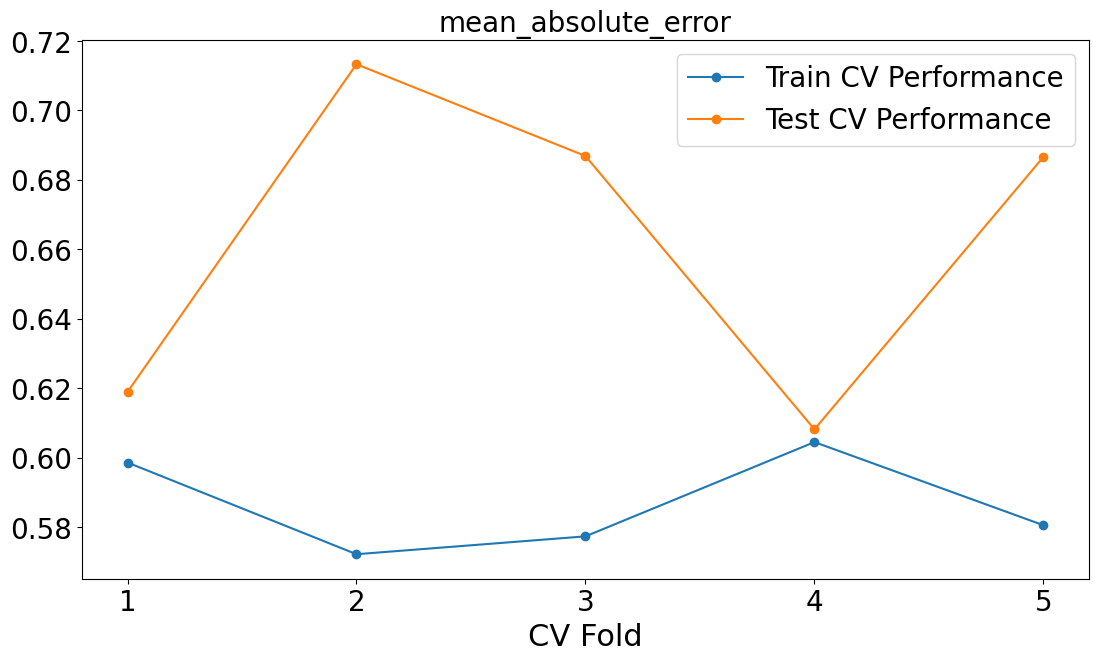

In [27]:
fold_accs_train_z, fold_accs_test_z = bbs(hcp_z, gscores, n_components=75, n_cv_splits=5, pred_summary_function=metrics.mean_absolute_error, verbose=True)

CV Fold: 1          Fitting PCA model...
CV Fold: 1          Fitting Linear Regression model...
CV Fold: 1          Train Accuracy: 0.622      Test Accuracy: 0.643     
CV Fold: 2          Fitting PCA model...
CV Fold: 2          Fitting Linear Regression model...
CV Fold: 2          Train Accuracy: 0.605      Test Accuracy: 0.723     
CV Fold: 3          Fitting PCA model...
CV Fold: 3          Fitting Linear Regression model...
CV Fold: 3          Train Accuracy: 0.604      Test Accuracy: 0.701     
CV Fold: 4          Fitting PCA model...
CV Fold: 4          Fitting Linear Regression model...
CV Fold: 4          Train Accuracy: 0.624      Test Accuracy: 0.646     
CV Fold: 5          Fitting PCA model...
CV Fold: 5          Fitting Linear Regression model...
CV Fold: 5          Train Accuracy: 0.614      Test Accuracy: 0.722     


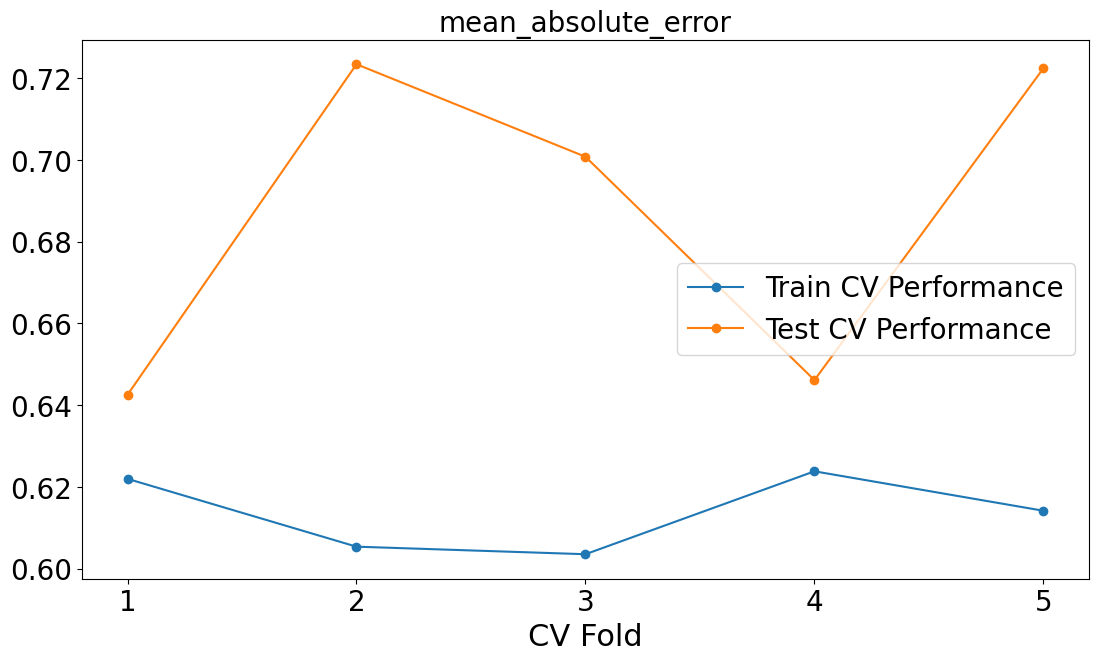

In [28]:
fold_accs_train_ct, fold_accs_test_ct = bbs(hcp_ct, gscores, n_components=75, n_cv_splits=5, pred_summary_function=metrics.mean_absolute_error, verbose=True)

# Connectome Predictive Modelling

In [29]:
# correlation train_brain with train_phenotype
train_z_pheno_corr_p = [stats.pearsonr(train_data_z[:, i], train_phen) for i in range(train_data_z.shape[1])]  # train_pheno_corr_p: (259200, )
# there are some nan correlations if brain data is poorly cropped (ie: some columns are always 0)

In [30]:
# correlation train_brain with train_phenotype
train_ct_pheno_corr_p = [stats.pearsonr(train_data_ct[:, i], train_phen) for i in range(train_data_ct.shape[1])]  # train_pheno_corr_p: (259200, )
# there are some nan correlations if brain data is poorly cropped (ie: some columns are always 0)

In [31]:
# split into positive and negative correlations
# and keep edges with p values below threshold
pval_threshold = 0.01

train_z_corrs = np.array([x[0] for x in train_z_pheno_corr_p])
train_z_pvals = np.array([x[1] for x in train_z_pheno_corr_p])

keep_edges_pos_z = (train_z_corrs > 0) & (train_z_pvals < pval_threshold)
keep_edges_neg_z = (train_z_corrs < 0) & (train_z_pvals < pval_threshold)

train_ct_corrs = np.array([x[0] for x in train_ct_pheno_corr_p])
train_ct_pvals = np.array([x[1] for x in train_ct_pheno_corr_p])

keep_edges_pos_ct = (train_ct_corrs > 0) & (train_ct_pvals < pval_threshold)
keep_edges_neg_ct = (train_ct_corrs < 0) & (train_ct_pvals < pval_threshold)

In [32]:
print(f'number of positive Z features kept = {np.sum(keep_edges_pos_z)}')
print(f'number of negative Z features kept = {np.sum(keep_edges_neg_z)}')
print(f'number of positive CT features kept = {np.sum(keep_edges_pos_ct)}')
print(f'number of negative CT features kept = {np.sum(keep_edges_neg_ct)}')

number of positive Z features kept = 37
number of negative Z features kept = 2
number of positive CT features kept = 15
number of negative CT features kept = 1


In [33]:
train_pos_edges_sum_z = train_data_z[:, keep_edges_pos_z].sum(1)
train_neg_edges_sum_z = train_data_z[:, keep_edges_neg_z].sum(1)

In [34]:
train_pos_edges_sum_ct = train_data_ct[:, keep_edges_pos_ct].sum(1)
train_neg_edges_sum_ct = train_data_ct[:, keep_edges_neg_ct].sum(1)

In [35]:
fit_pos_z = linear_model.LinearRegression(fit_intercept=True).fit(train_pos_edges_sum_z.reshape(-1, 1), train_phen)
fit_neg_z = linear_model.LinearRegression(fit_intercept=True).fit(train_neg_edges_sum_z.reshape(-1, 1), train_phen)

In [36]:
fit_pos_ct = linear_model.LinearRegression(fit_intercept=True).fit(train_pos_edges_sum_ct.reshape(-1, 1), train_phen)
fit_neg_ct = linear_model.LinearRegression(fit_intercept=True).fit(train_neg_edges_sum_ct.reshape(-1, 1), train_phen)

In [37]:
pos_error_z = metrics.mean_absolute_error(train_phen, fit_pos_z.predict(train_pos_edges_sum_z.reshape(-1, 1)))
neg_error_z = metrics.mean_absolute_error(train_phen, fit_neg_z.predict(train_neg_edges_sum_z.reshape(-1, 1)))
pos_error_ct = metrics.mean_absolute_error(train_phen, fit_pos_ct.predict(train_pos_edges_sum_ct.reshape(-1, 1)))
neg_error_ct = metrics.mean_absolute_error(train_phen, fit_neg_ct.predict(train_neg_edges_sum_ct.reshape(-1, 1)))

print(f'Training Error (Positive Z Features Model) = {pos_error_z:.3f}')
print(f'Training Error (Negative Z Features Model) = {neg_error_z:.3f}')
print(f'Training Error (Positive CT Features Model) = {pos_error_ct:.3f}')
print(f'Training Error (Negative CT Features Model) = {neg_error_ct:.3f}')

Training Error (Positive Z Features Model) = 0.631
Training Error (Negative Z Features Model) = 0.666
Training Error (Positive CT Features Model) = 0.662
Training Error (Negative CT Features Model) = 0.665


In [38]:
# combine positive/negative edges in one linear regression model
fit_pos_neg_z = linear_model.LinearRegression(fit_intercept=True).fit(np.stack((train_pos_edges_sum_z, train_neg_edges_sum_z)).T, train_phen)

In [39]:
# combine positive/negative edges in one linear regression model
fit_pos_neg_ct = linear_model.LinearRegression(fit_intercept=True).fit(np.stack((train_pos_edges_sum_ct, train_neg_edges_sum_ct)).T, train_phen)

In [40]:
pos_neg_error_z = metrics.mean_absolute_error(train_phen, fit_pos_neg_z.predict(np.stack((train_pos_edges_sum_z, train_neg_edges_sum_z)).T))
pos_neg_error_ct = metrics.mean_absolute_error(train_phen, fit_pos_neg_ct.predict(np.stack((train_pos_edges_sum_ct, train_neg_edges_sum_ct)).T))

print(f'Training Error (Positive/Negative Z Features Model) = {pos_neg_error_z:.3f}')
print(f'Training Error (Positive/Negative CT Features Model) = {pos_neg_error_ct:.3f}')

Training Error (Positive/Negative Z Features Model) = 0.620
Training Error (Positive/Negative CT Features Model) = 0.642


In [41]:
# evaluate out of sample performance
test_pos_edges_sum_z = test_data_z[:, keep_edges_pos_z].sum(1)
test_neg_edges_sum_z = test_data_z[:, keep_edges_neg_z].sum(1)

pos_test_error_z = metrics.mean_absolute_error(test_phen, fit_pos_z.predict(test_pos_edges_sum_z.reshape(-1, 1)))
neg_test_error_z = metrics.mean_absolute_error(test_phen, fit_neg_z.predict(test_neg_edges_sum_z.reshape(-1, 1)))
pos_neg_test_error_z = metrics.mean_absolute_error(test_phen, fit_pos_neg_z.predict(np.stack((test_pos_edges_sum_z, test_neg_edges_sum_z)).T))

test_pos_edges_sum_ct = test_data_ct[:, keep_edges_pos_ct].sum(1)
test_neg_edges_sum_ct = test_data_ct[:, keep_edges_neg_ct].sum(1)

pos_test_error_ct = metrics.mean_absolute_error(test_phen, fit_pos_ct.predict(test_pos_edges_sum_ct.reshape(-1, 1)))
neg_test_error_ct = metrics.mean_absolute_error(test_phen, fit_neg_ct.predict(test_neg_edges_sum_ct.reshape(-1, 1)))
pos_neg_test_error_ct = metrics.mean_absolute_error(test_phen, fit_pos_neg_ct.predict(np.stack((test_pos_edges_sum_ct, test_neg_edges_sum_ct)).T))

print(f'Testing Error (Positive Z Features Model) = {pos_test_error_z:.3f}')
print(f'Testing Error (Negative Z Features Model) = {neg_test_error_z:.3f}')
print(f'Testing Error (Positive/Negative Z Features Model) = {pos_neg_test_error_z:.3f}')
print(f'Testing Error (Positive CT Features Model) = {pos_test_error_ct:.3f}')
print(f'Testing Error (Negative CT Features Model) = {neg_test_error_ct:.3f}')
print(f'Testing Error (Positive/Negative CT Features Model) = {pos_neg_test_error_ct:.3f}')

Testing Error (Positive Z Features Model) = 0.705
Testing Error (Negative Z Features Model) = 0.696
Testing Error (Positive/Negative Z Features Model) = 0.697
Testing Error (Positive CT Features Model) = 0.710
Testing Error (Negative CT Features Model) = 0.695
Testing Error (Positive/Negative CT Features Model) = 0.701


## CPM Cross Validation

In [42]:
def cpm(X, y, p_threshold, n_cv_splits, pred_summary_function, verbose=False):
    assert X.shape[0] == y.shape[0]

    fold_accs_train = []
    fold_accs_test = []
    np.random.seed(42)
    shuffled_idxs = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    for fold_i, test_idxs in enumerate(np.array_split(shuffled_idxs, n_cv_splits)):
        train_mask = np.ones(X.shape[0], bool)
        train_mask[test_idxs] = 0

        # create train/text X, y
        train_X, test_X = X[train_mask, :], X[test_idxs, :]
        train_y, test_y = y[train_mask], y[test_idxs]

        # create correlation matrix between train_X and train_y
        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Computing correlations between train_X and train_y...')
        with warnings.catch_warnings():
            # we expect pearsonr to throw PearsonRConstantInputWarning because of contant valued columns in X
            warnings.simplefilter("ignore")
            train_pheno_corr_p = [stats.pearsonr(train_X[:, i], train_y) for i in range(train_X.shape[1])]
            train_corrs = np.array([x[0] for x in train_pheno_corr_p])
            train_pvals = np.array([x[1] for x in train_pheno_corr_p])
            # create masks for edges below p-threshold and split pos/neg correlations
            keep_edges_pos = (train_corrs > 0) & (train_pvals < p_threshold)
            keep_edges_neg = (train_corrs < 0) & (train_pvals < p_threshold)

        # sum X entries with significant correlations with y
        train_pos_edges_sum = train_X[:, keep_edges_pos].sum(1)
        train_neg_edges_sum = train_X[:, keep_edges_neg].sum(1)
        test_pos_edges_sum = test_X[:, keep_edges_pos].sum(1)
        test_neg_edges_sum = test_X[:, keep_edges_neg].sum(1)

        # fit linear regression models based on summed values
        fit_pos = linear_model.LinearRegression(fit_intercept=True).fit(train_pos_edges_sum.reshape(-1, 1), train_y)
        fit_neg = linear_model.LinearRegression(fit_intercept=True).fit(train_neg_edges_sum.reshape(-1, 1), train_y)
        fit_pos_neg = linear_model.LinearRegression(fit_intercept=True).fit(np.stack((train_pos_edges_sum, train_neg_edges_sum)).T, train_y)

        # compute train errors
        train_pos_error = pred_summary_function(train_y, fit_pos.predict(train_pos_edges_sum.reshape(-1, 1)))
        train_neg_error = pred_summary_function(train_y, fit_neg.predict(train_neg_edges_sum.reshape(-1, 1)))
        train_posneg_error = pred_summary_function(train_y, fit_pos_neg.predict(np.stack((train_pos_edges_sum, train_neg_edges_sum)).T))

        # compute testing errors
        test_pos_error = pred_summary_function(test_y, fit_pos.predict(test_pos_edges_sum.reshape(-1, 1)))
        test_neg_error = pred_summary_function(test_y, fit_neg.predict(test_neg_edges_sum.reshape(-1, 1)))
        test_posneg_error = pred_summary_function(test_y, fit_pos_neg.predict(np.stack((test_pos_edges_sum, test_neg_edges_sum)).T))

        fold_accs_train.append((train_pos_error, train_neg_error, train_posneg_error))
        fold_accs_test.append((test_pos_error, test_neg_error, test_posneg_error))

        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Train Pos-Edges Model Accuracy: {round(train_pos_error, 3):<10} Train Neg-Edges Model Accuracy: {round(train_neg_error, 3):<10} Train Pos/Neg-Edges Model Accuracy: {round(train_posneg_error, 3):<10}')
            print(f'CV Fold: {fold_i+1:<10} Test  Pos-Edges Model Accuracy: {round(test_pos_error, 3):<10} Test  Neg-Edges Model Accuracy: {round(test_neg_error, 3):<10} Test  Pos/Neg-Edges Model Accuracy: {round(test_posneg_error, 3):<10}')


    plt.figure(figsize=(13, 7))
    plt.plot(range(1, len(fold_accs_train)+1), [x[0] for x in fold_accs_train], linestyle='--', marker='o', color='C0', label='Train Pos-Edges Model')
    plt.plot(range(1, len(fold_accs_train)+1), [x[1] for x in fold_accs_train], linestyle='--', marker='o', color='C1', label='Train Neg-Edges Model')
    plt.plot(range(1, len(fold_accs_train)+1), [x[2] for x in fold_accs_train], linestyle='--', marker='o', color='C2', label='Train Pos/Neg-Edges Model')

    plt.plot(range(1, len(fold_accs_test)+1), [x[0] for x in fold_accs_test], linestyle='-', marker='o', color='C0', label='Test  Pos-Edges Model')
    plt.plot(range(1, len(fold_accs_test)+1), [x[1] for x in fold_accs_test], linestyle='-', marker='o', color='C1', label='Test  Neg-Edges Model')
    plt.plot(range(1, len(fold_accs_test)+1), [x[2] for x in fold_accs_test], linestyle='-', marker='o', color='C2', label='Test  Pos/Neg-Edges Model')

    plt.title(pred_summary_function.__name__, fontsize=20)
    plt.xticks(range(1, len(fold_accs_test)+1))
    plt.xlabel('CV Fold')
    plt.legend(fontsize=10)
    plt.show()

    return fold_accs_train, fold_accs_test

CV Fold: 1          Computing correlations between train_X and train_y...
CV Fold: 1          Train Pos-Edges Model Accuracy: 0.652      Train Neg-Edges Model Accuracy: 0.673      Train Pos/Neg-Edges Model Accuracy: 0.644     
CV Fold: 1          Test  Pos-Edges Model Accuracy: 0.636      Test  Neg-Edges Model Accuracy: 0.671      Test  Pos/Neg-Edges Model Accuracy: 0.632     
CV Fold: 2          Computing correlations between train_X and train_y...
CV Fold: 2          Train Pos-Edges Model Accuracy: 0.648      Train Neg-Edges Model Accuracy: 0.678      Train Pos/Neg-Edges Model Accuracy: 0.636     
CV Fold: 2          Test  Pos-Edges Model Accuracy: 0.651      Test  Neg-Edges Model Accuracy: 0.659      Test  Pos/Neg-Edges Model Accuracy: 0.662     
CV Fold: 3          Computing correlations between train_X and train_y...
CV Fold: 3          Train Pos-Edges Model Accuracy: 0.644      Train Neg-Edges Model Accuracy: 0.662      Train Pos/Neg-Edges Model Accuracy: 0.636     
CV Fold: 3   

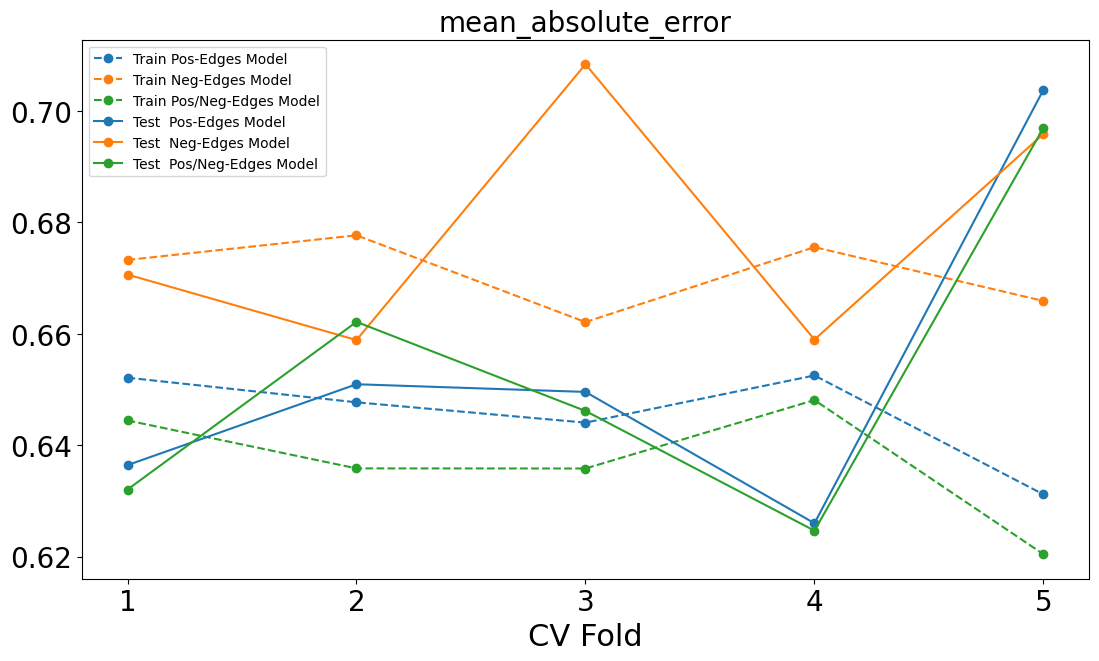

In [43]:
fold_accs_train_z, fold_accs_test_z = cpm(hcp_z, gscores, p_threshold=0.01, n_cv_splits=5, pred_summary_function=metrics.mean_absolute_error, verbose=True)

CV Fold: 1          Computing correlations between train_X and train_y...
CV Fold: 1          Train Pos-Edges Model Accuracy: 0.675      Train Neg-Edges Model Accuracy: 0.673      Train Pos/Neg-Edges Model Accuracy: 0.659     
CV Fold: 1          Test  Pos-Edges Model Accuracy: 0.659      Test  Neg-Edges Model Accuracy: 0.67       Test  Pos/Neg-Edges Model Accuracy: 0.653     
CV Fold: 2          Computing correlations between train_X and train_y...
CV Fold: 2          Train Pos-Edges Model Accuracy: 0.674      Train Neg-Edges Model Accuracy: 0.678      Train Pos/Neg-Edges Model Accuracy: 0.636     
CV Fold: 2          Test  Pos-Edges Model Accuracy: 0.661      Test  Neg-Edges Model Accuracy: 0.657      Test  Pos/Neg-Edges Model Accuracy: 0.668     
CV Fold: 3          Computing correlations between train_X and train_y...
CV Fold: 3          Train Pos-Edges Model Accuracy: 0.659      Train Neg-Edges Model Accuracy: 0.665      Train Pos/Neg-Edges Model Accuracy: 0.644     
CV Fold: 3   

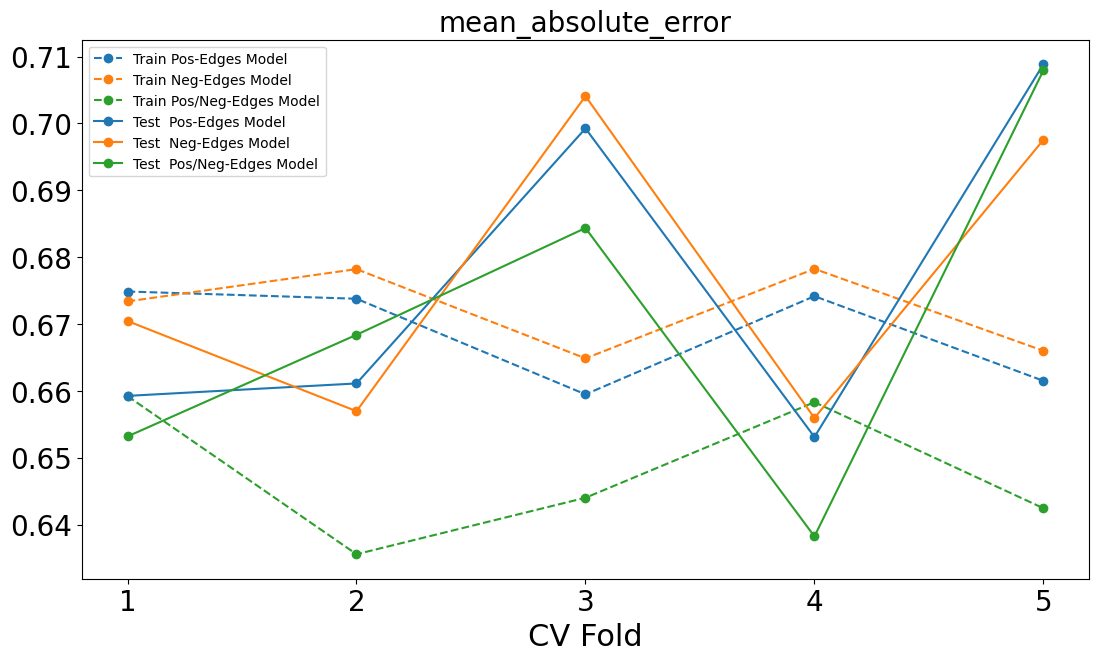

In [44]:
fold_accs_train_ct, fold_accs_test_ct = cpm(hcp_ct, gscores, p_threshold=0.01, n_cv_splits=5, pred_summary_function=metrics.mean_absolute_error, verbose=True)

# Lasso (Linear Regression + L1 Regularization)

In [45]:
# LassoCV uses coordinate descent to select hyperparameter alpha
alpha_grid = np.array([10**a for a in np.arange(-3, 3, 0.25)])
lassoCV_model_z = linear_model.LassoCV(cv=5, n_alphas=len(alpha_grid), alphas=alpha_grid, fit_intercept=True, random_state=42, verbose=True, n_jobs=5).fit(train_data_z, train_phen)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
.....................................................................................................................[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07308221069854426, tolerance: 0.04611195889050071
  model = cd_fast.enet_coordinate_descent_gram(
./usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15375414865695802, tolerance: 0.03970345334827422
  model = cd_fast.enet_coordinate_descent_gram(
./usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Object

In [46]:
# LassoCV uses coordinate descent to select hyperparameter alpha
alpha_grid = np.array([10**a for a in np.arange(-3, 3, 0.25)])
lassoCV_model_ct = linear_model.LassoCV(cv=5, n_alphas=len(alpha_grid), alphas=alpha_grid, fit_intercept=True,  random_state=42, verbose=True, n_jobs=5).fit(train_data_ct, train_phen)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
....................................................................................................................[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
....[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.3s finished


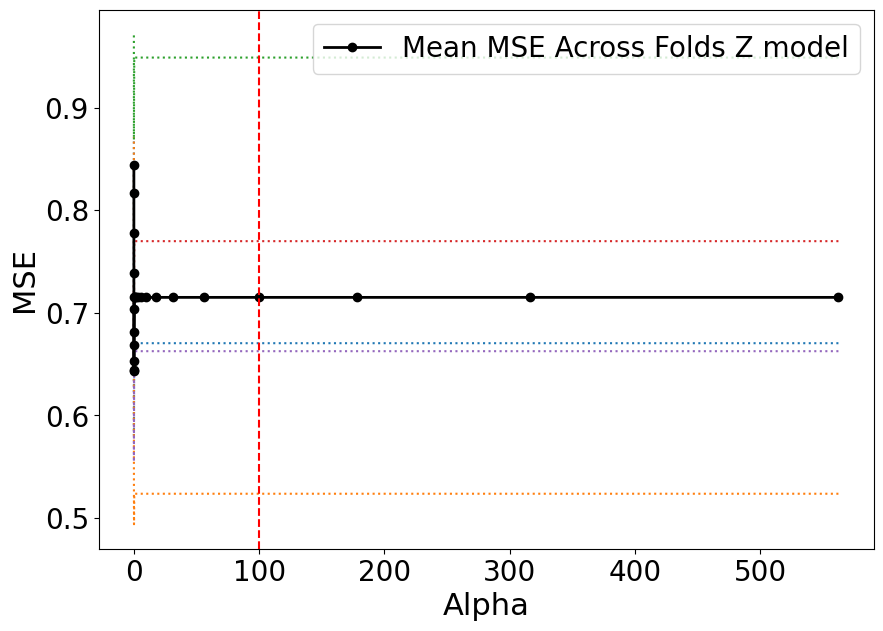

In [47]:
plt.figure(figsize=(10, 7))
plt.plot(lassoCV_model_z.alphas_, lassoCV_model_z.mse_path_, ':')
plt.plot(lassoCV_model_z.alphas_, lassoCV_model_z.mse_path_.mean(axis=-1), color='k', marker='o', label='Mean MSE Across Folds Z model', linewidth=2)
plt.axvline(x=100, linestyle='--', c='r')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

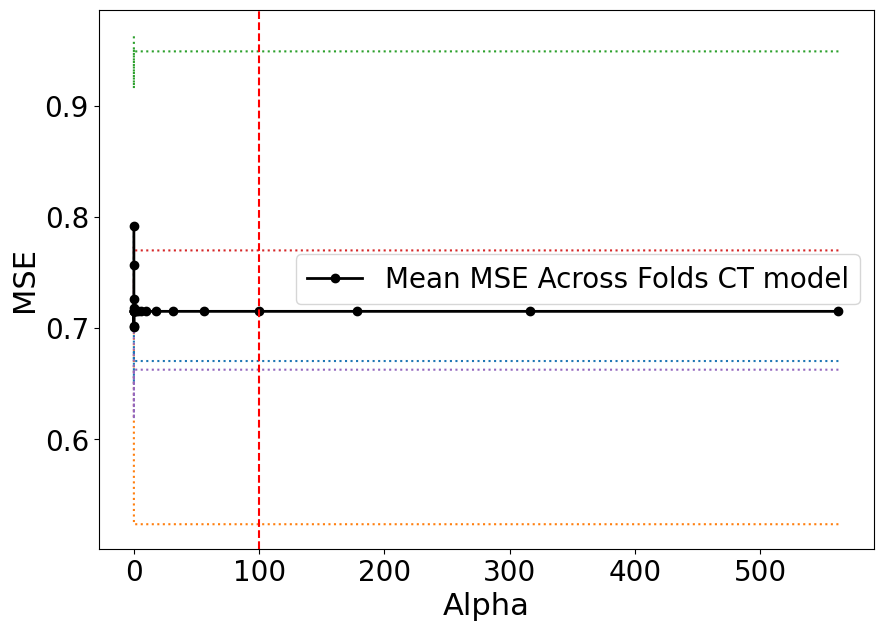

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(lassoCV_model_ct.alphas_, lassoCV_model_ct.mse_path_, ':')
plt.plot(lassoCV_model_ct.alphas_, lassoCV_model_ct.mse_path_.mean(axis=-1), color='k', marker='o', label='Mean MSE Across Folds CT model', linewidth=2)
plt.axvline(x=100, linestyle='--', c='r')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [49]:
# based on cv results above, set alpha=100
lasso_model_z = linear_model.Lasso(alpha=lassoCV_model_z.alpha_, fit_intercept=True).fit(train_data_z, train_phen)

In [50]:
# based on cv results above, set alpha=100
lasso_model_ct = linear_model.Lasso(alpha=lassoCV_model_ct.alpha_, fit_intercept=True).fit(train_data_ct, train_phen)

In [51]:
train_preds_lasso_model_z = lasso_model_z.predict(train_data_z)
test_preds_lasso_model_z = lasso_model_z.predict(test_data_z)

train_mae_z = metrics.mean_absolute_error(train_phen, train_preds_lasso_model_z)
test_mae_z = metrics.mean_absolute_error(test_phen, test_preds_lasso_model_z)

train_preds_lasso_model_ct = lasso_model_ct.predict(train_data_ct)
test_preds_lasso_model_ct = lasso_model_ct.predict(test_data_ct)

train_mae_ct = metrics.mean_absolute_error(train_phen, train_preds_lasso_model_ct)
test_mae_ct = metrics.mean_absolute_error(test_phen, test_preds_lasso_model_ct)

print(f'Train MAE Z model: {train_mae_z:.3f}')
print(f'Test MAE Z model: {test_mae_z:.3f}')
print(f'Train MAE CT model: {train_mae_ct:.3f}')
print(f'Test MAE CT model: {test_mae_ct:.3f}')

Train MAE Z model: 0.620
Test MAE Z model: 0.682
Train MAE CT model: 0.650
Test MAE CT model: 0.697


# Ridge (Linear Regression + L2 Regularization)

In [52]:
# RidgeCV uses generalized cross validation to select hyperparameter alpha
with warnings.catch_warnings():
    # ignore matrix decomposition errors
    warnings.simplefilter("ignore")
    ridgeCV_model_z = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, cv=5).fit(train_data_z, train_phen)

In [53]:
# RidgeCV uses generalized cross validation to select hyperparameter alpha
with warnings.catch_warnings():
    # ignore matrix decomposition errors
    warnings.simplefilter("ignore")
    ridgeCV_model_ct = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True,  cv=5).fit(train_data_ct, train_phen)

In [54]:
ridge_alpha_z = ridgeCV_model_z.alpha_
print(f'CV Selected Alpha Z model = {ridge_alpha_z:.3f}')

CV Selected Alpha Z model = 10.000


In [55]:
ridge_alpha_ct = ridgeCV_model_ct.alpha_
print(f'CV Selected Alpha CT model = {ridge_alpha_ct:.3f}')

CV Selected Alpha CT model = 10.000


In [56]:
ridge_model_z = linear_model.Ridge(alpha=ridge_alpha_z, fit_intercept=True).fit(train_data_z, train_phen)

In [57]:
ridge_model_ct = linear_model.Ridge(alpha=ridge_alpha_ct, fit_intercept=True).fit(train_data_ct, train_phen)

In [58]:
train_preds_ridge_model_z = ridge_model_z.predict(train_data_z)
test_preds_ridge_model_z = ridge_model_z.predict(test_data_z)

train_mae_z = metrics.mean_absolute_error(train_phen, train_preds_ridge_model_z)
test_mae_z = metrics.mean_absolute_error(test_phen, test_preds_ridge_model_z)

train_preds_ridge_model_ct = ridge_model_ct.predict(train_data_ct)
test_preds_ridge_model_ct = ridge_model_ct.predict(test_data_ct)

train_mae_ct = metrics.mean_absolute_error(train_phen, train_preds_ridge_model_ct)
test_mae_ct = metrics.mean_absolute_error(test_phen, test_preds_ridge_model_ct)

print(f'Train MAE Z model: {train_mae_z:.3f}')
print(f'Test MAE Z model: {test_mae_z:.3f}')
print(f'Train MAE CT model: {train_mae_ct:.3f}')
print(f'Test MAE CT model: {test_mae_ct:.3f}')

Train MAE Z model: 0.527
Test MAE Z model: 0.734
Train MAE CT model: 0.600
Test MAE CT model: 0.692


# Elastic Net (Linear Regression + L1/L2 Regularization)

In [59]:
# RidgeCV uses generalized cross validation to select hyperparameter alpha
elasticnetCV_model_z = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_alphas=len(alpha_grid), alphas=alpha_grid, random_state=42, verbose=True, n_jobs=5).fit(train_data_z, train_phen)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
............................................................................................................./usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21318694590257792, tolerance: 0.0423918944559644
  model = cd_fast.enet_coordinate_descent_gram(
./usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17936527851907158, tolerance: 0.03970345334827422
  model = cd_fast.enet_coordinate_descent_gram(
.../usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

In [60]:
# RidgeCV uses generalized cross validation to select hyperparameter alpha
elasticnetCV_model_ct = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_alphas=len(alpha_grid), alphas=alpha_grid, random_state=42, verbose=True, n_jobs=5).fit(train_data_ct, train_phen)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:    1.8s finished


In [61]:
print(f'CV selected alpha Z model {elasticnetCV_model_z.alpha_:.3f}')
print(f'Elastic net L1 ratio Z model {elasticnetCV_model_z.l1_ratio_:.3f}')
print(f'CV selected alpha CT model {elasticnetCV_model_ct.alpha_:.3f}')
print(f'Elastic net L1 ratio CT model {elasticnetCV_model_ct.l1_ratio_:.3f}')

CV selected alpha Z model 0.056
Elastic net L1 ratio Z model 0.700
CV selected alpha CT model 0.032
Elastic net L1 ratio CT model 0.100


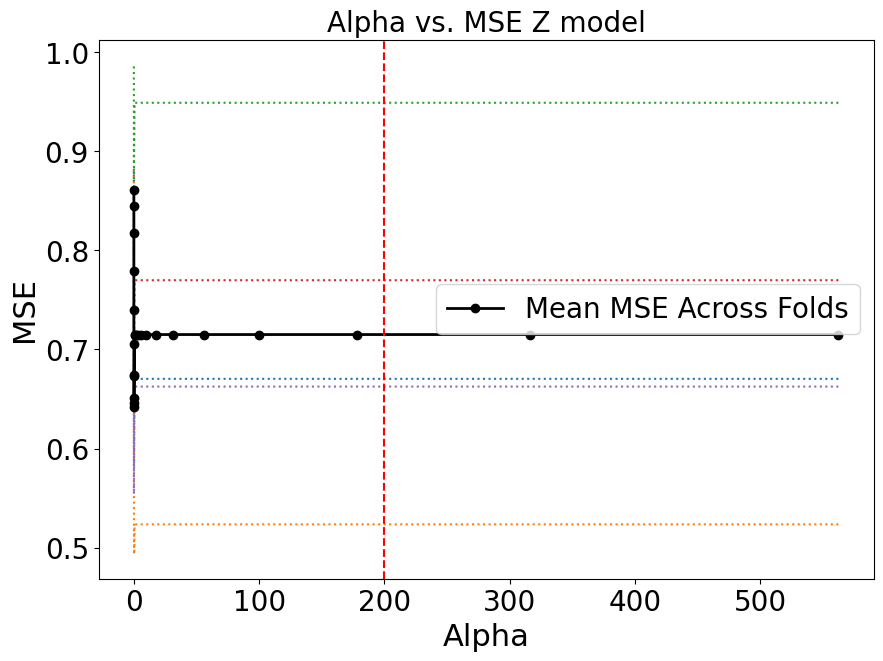

In [62]:
plt.figure(figsize=(10, 7))
plt.plot(elasticnetCV_model_z.alphas_, elasticnetCV_model_z.mse_path_[1, :, :], ':')
plt.plot(elasticnetCV_model_z.alphas_, elasticnetCV_model_z.mse_path_[1, :, :].mean(axis=-1), color='k', marker='o', label='Mean MSE Across Folds', linewidth=2)
plt.axvline(x=200, linestyle='--', c='r')
plt.title('Alpha vs. MSE Z model')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

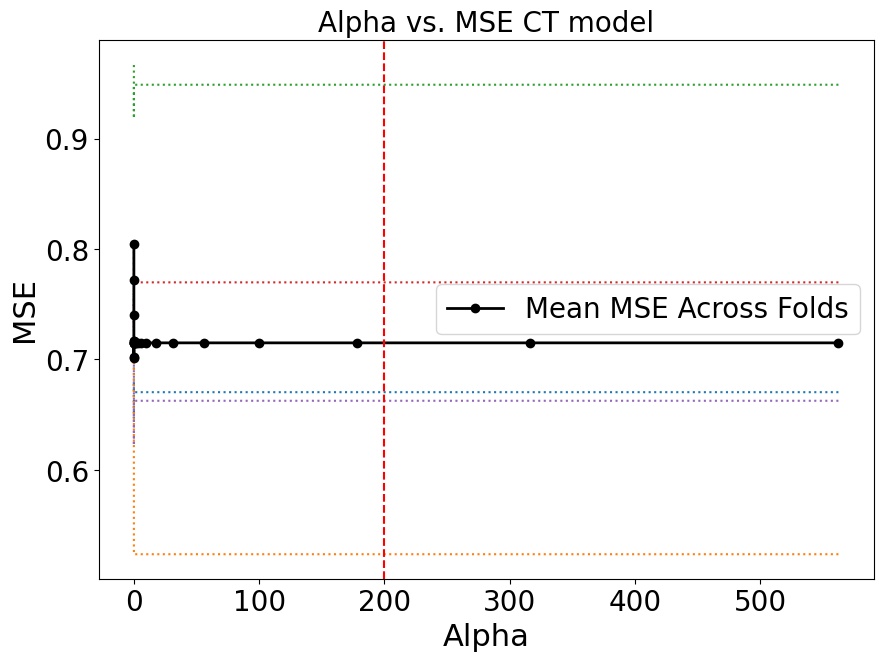

In [63]:
plt.figure(figsize=(10, 7))
plt.plot(elasticnetCV_model_ct.alphas_, elasticnetCV_model_ct.mse_path_[1, :, :], ':')
plt.plot(elasticnetCV_model_ct.alphas_, elasticnetCV_model_ct.mse_path_[1, :, :].mean(axis=-1), color='k', marker='o', label='Mean MSE Across Folds', linewidth=2)
plt.axvline(x=200, linestyle='--', c='r')
plt.title('Alpha vs. MSE CT model')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [64]:
elasticnet_model_z = linear_model.ElasticNet(alpha=elasticnetCV_model_z.alpha_, l1_ratio=elasticnetCV_model_z.l1_ratio_, fit_intercept=True,  random_state=42).fit(train_data_z, train_phen)

train_preds_en_model_z = elasticnet_model_z.predict(train_data_z)
test_preds_en_model_z = elasticnet_model_z.predict(test_data_z)

train_mae_z = metrics.mean_absolute_error(train_phen, train_preds_en_model_z)
test_mae_z = metrics.mean_absolute_error(test_phen, test_preds_en_model_z)

elasticnet_model_ct = linear_model.ElasticNet(alpha=elasticnetCV_model_ct.alpha_, l1_ratio=elasticnetCV_model_ct.l1_ratio_, fit_intercept=True, random_state=42).fit(train_data_ct, train_phen)

train_preds_en_model_ct = elasticnet_model_ct.predict(train_data_ct)
test_preds_en_model_ct = elasticnet_model_ct.predict(test_data_ct)

train_mae_ct = metrics.mean_absolute_error(train_phen, train_preds_en_model_ct)
test_mae_ct = metrics.mean_absolute_error(test_phen, test_preds_en_model_ct)

print(f'Train MAE Z model: {train_mae_z:.3f}')
print(f'Test MAE Z model: {test_mae_z:.3f}')
print(f'Train MAE CT model: {train_mae_ct:.3f}')
print(f'Test MAE CT model: {test_mae_ct:.3f}')

Train MAE Z model: 0.611
Test MAE Z model: 0.680
Train MAE CT model: 0.633
Test MAE CT model: 0.692
